In [ ]:
import torch
import numpy as np
from PIL import Image

#### 1: Setting up device agnostice code

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
import sklearn
from sklearn.datasets import make_circles

In [ ]:
#### Dumy datasest from skleanr
n_samples = 1000

X , Y = make_circles(n_samples , random_state = 42 , noise = 0.05)
X = X.astype(np.float32)
Y = Y.astype(np.float32)

In [ ]:
X[0] , Y[0]

(array([0.7422069 , 0.24668576], dtype=float32), 1.0)

 #### 2: Putting the dataa into a panda

In [ ]:
import pandas as pd

circles_pd = pd.DataFrame({"X1":X[:,0],
                           "X2":X[:,1],
                           "labels":Y})

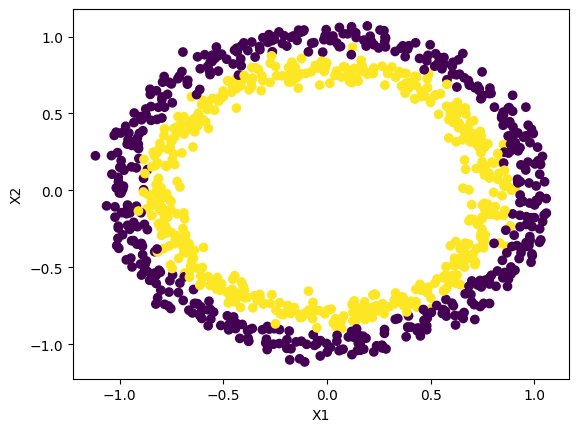

In [ ]:
# @title Scatter plot of X1 vs X2

import matplotlib.pyplot as plt
plt.scatter(circles_pd['X1'], circles_pd['X2'], c=circles_pd['labels'], cmap='viridis')
plt.xlabel('X1')
_ = plt.ylabel('X2')

In [ ]:
### splitting the data by indexing

train_size = int(0.8 * len(X))

X_train , Y_train = X[:train_size] , Y[:train_size]
X_test , Y_test = X[train_size:] , Y[train_size:]

#### ***3:splitting using the sklearn train_test_split***


`train_test_split`

In [ ]:


from sklearn.model_selection import train_test_split
X_train , X_test , y_train , y_test = train_test_split(X , Y , test_size = 0.2 , random_state = 42 )

In [ ]:
def plot(X_train , y_train):
  plt.scatter(X_train[:,0] , X_train[:,1] , c =y_train)

#### ***4: Transforming data to tensors***

In [ ]:


X_train =  torch.from_numpy(X_train)
y_train  = torch.from_numpy(y_train)

X_test =  torch.from_numpy(X_test)
y_test  = torch.from_numpy(y_test)

In [ ]:
y_train = y_train.unsqueeze(1)
y_test = y_test .unsqueeze(1)

In [ ]:
y_test.shape

torch.Size([200, 1])

In [ ]:
#### putting the data into device

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

### ***5 : Biulding the model***

The model subclasses the `torch.nn` module

1. Sublass the torch.nn

2. Create 2 `nn.Linear() layers

3. Define a forward method

4. Instantiate an instance of the model

In [ ]:
from torch import nn
from collections import OrderedDict
import copy

class CircleModel(nn.Module):

  def __init__(self):
      super().__init__()

      ## 2  create the 2 nn.Linnear layers
      self.layer_1 = nn.Linear(in_features = 2 , out_features = 50)
      self.layer_2 = nn.Linear(in_features = 50 , out_features = 1)

  ## 3
  def forward(self , X):
      return self.layer_2(self.layer_1(X))

  def sequential_model(self ,layers):
      """
      layers = [num_layers [(in_features , out_features)]
      """
      orderd_dict = {}
      for i in range(len(layers)):

        name  , in_f , out_f = layers[i]
        layer = name( in_f , out_f)

        layer_name = name.__name__ + str(i+1)

        orderd_dict[layer_name] = layer

      return nn.Sequential(OrderedDict(orderd_dict))


### 4 Instantiating the model

model_0 = CircleModel().to(device)




#### another way to create the model using the `nn.Sequential()`

In [ ]:
def sequential_model(layers):
    """
    layers = [layer name [(in_features , out_features)]
    """
    orderd_dict = {}
    for i in range(len(layers)):

      name  , in_f , out_f = layers[i]
      layer = name( in_f , out_f)

      layer_name = name.__name__ + str(i+1)

      orderd_dict[layer_name] = layer

    return nn.Sequential(OrderedDict(orderd_dict))


model_1 = sequential_model([
                            (nn.Linear , 2 , 10),
                            (nn.Linear , 10 , 1) ]
                          )



In [ ]:
with torch.inference_mode():
  y_pred = model_1(X_test)

#### ***6: Setting up the loss and optimizer and the training loop***

In [ ]:


model_0 = CircleModel().to(device)
loss_fn = torch.nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(params = model_0.parameters() , lr = 0.1)


### define the acc funtion
def accuracy_fn(y_true , y_pred):

    correct = torch.eq(y_true , y_pred).sum().item()
    acc = (correct/len(y_true))* 100

    return acc



#### training loop

train_data={}
EPOCHS = 1000

for epoch in range(1 , EPOCHS+1):

    model_0.train()

    ## 1 Forward
    y_logits = model_0(X_train)

    ## 2 train losss/acc

    y_preds = torch.round(torch.sigmoid(y_logits))
    loss = loss_fn(y_logits , y_train)
    train_acc = accuracy_fn(y_train,y_preds)

    # 3 optimizer zero grad

    optim.zero_grad()

    # 4 Loss back ward

    loss.backward()

    #  5 Optimizer step

    optim.step()

    # Testing

    model_0.eval()
    with torch.inference_mode():

      y_pred_test_logits = model_0(X_test)

      y_pred_test = torch.round(torch.sigmoid(y_pred_test_logits))

      test_loss = loss_fn(y_pred_test_logits , y_test)
      test_acc = accuracy_fn(y_test , y_pred_test)


    if epoch == 1:
      train_data['train_loss'] = [loss.detach().cpu()]
      train_data['test_loss'] = [test_loss]
      train_data['train_acc'] = [train_acc]
      train_data['test_acc'] = [test_acc]

    else:

      if test_acc  >  max(train_data['test_acc']):
        if test_loss < min(train_data['test_loss']):
          print(f"Model acc improved to {test_acc}")
          print("saved the model")
          torch.save(copy.deepcopy(model_0) , 'best.pt')

      train_data['train_loss'].append(loss.detach().cpu())
      train_data['test_loss'].append(test_loss)
      train_data['train_acc'].append(train_acc)
      train_data['test_acc'].append(test_acc)

    if epoch % 100 == 0:
      print(test_loss , test_acc)



Model acc improved to 50.5
saved the model
tensor(0.6947) 45.5
tensor(0.6947) 45.5
tensor(0.6947) 45.5
tensor(0.6947) 45.5
tensor(0.6947) 45.5
tensor(0.6947) 45.5
tensor(0.6947) 47.0
tensor(0.6947) 45.5
tensor(0.6947) 45.5
tensor(0.6947) 45.5


In [ ]:
file = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"

import requests

req = requests.get(file)

with open("helper_functions.py" , 'wb') as f:
  cont = req.content
  f.write(cont)


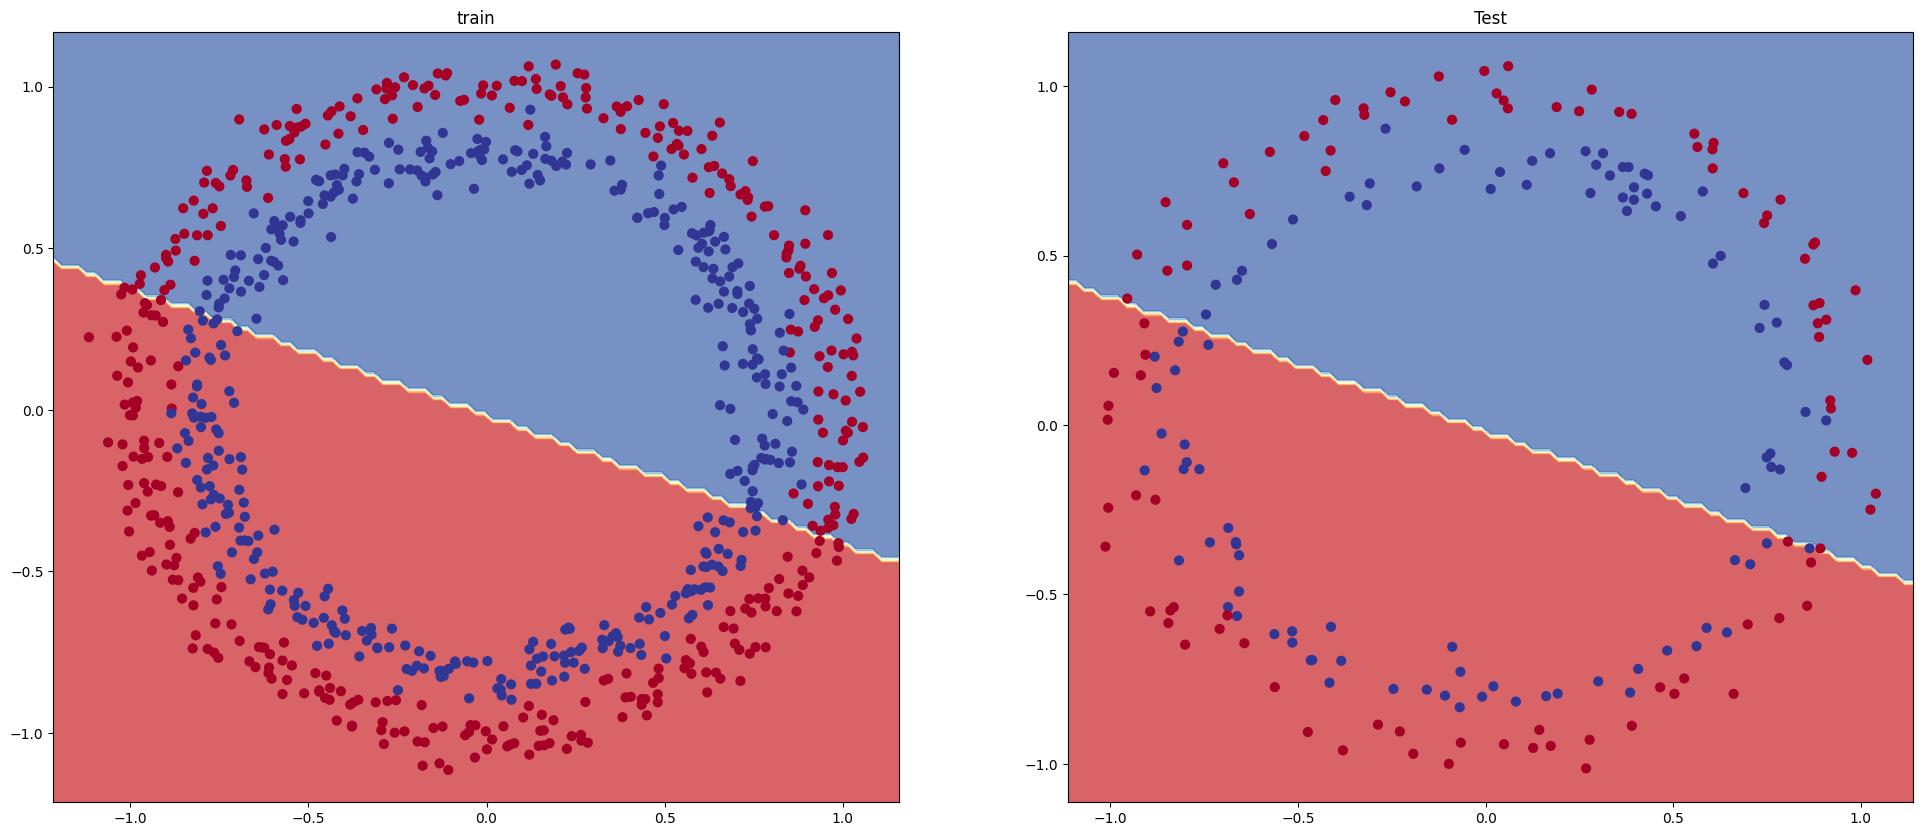

In [ ]:
### plot decission boundary for model
from matplotlib import pyplot as plt
from helper_functions import plot_predictions , plot_decision_boundary


plt.figure(figsize = (24 , 10))
plt.subplot(1 , 2 , 1)
plt.title("train")
plot_decision_boundary(model_0 , X_train , y_train)
plt.subplot(1 , 2, 2)
plt.title("Test")
plot_decision_boundary(model_0 , X_test , y_test)



#### ***5: Improving the models perfomance***

* 1 Add more layers
* 2 Add more hidden units
* 3 Add more Epochs
* 4 Change the activation function
* 5 Change the learning rate

***Fun fact z repersents the logits***

In [ ]:
class CircleModelV1(nn.Module):
    def __init__(self):
      super().__init__()
      self.layer1 = nn.Linear(2 , 100)
      self.layer2 = nn.Linear(100 , 105)
      self.layer3 = nn.Linear(105 , 1)
      self.layer4 = nn.Linear(100 , 100)
      self.relu = nn.ReLU()

    def forward(self , X):

      z = self.layer1(X)
      z = self.relu(z)
      z = self.layer4(z)
      z = self.relu(z)
      z = self.layer2(z)
      z = self.relu(z)
      z = self.layer3(z)

      return z

model_1 = CircleModelV1().to(device)

loss_fn = torch.nn.BCEWithLogitsLoss()
optim = torch.optim.Adam(model_1.parameters() , lr = 0.001)


### Training loop

epochs = 1000

h = []
for epoch in range(1 , epochs+ 1):

  model_1.train()

  y_preds_logits = model_1(X_train)

  y_preds = torch.round(torch.sigmoid(y_preds))
  train_acc = accuracy_fn(y_train , y_preds)

  loss = loss_fn(y_preds_logits , y_train)

  optim.zero_grad()

  loss.backward()

  optim.step()

  model_1.eval()

  with torch.inference_mode():

    y_preds_test_logits = model_1(X_test)

    test_loss = loss_fn(y_pred_test_logits , y_test)

    test_preds = torch.round(torch.sigmoid(y_pred_test_logits))

    test_acc = accuracy_fn(y_test , test_preds)

  if epoch % 100 ==0 :
    print(f"{epoch} |Train loss {loss} | train accuracy {train_acc} | Test loss {test_loss} | Test accuracy {test_acc}")

  if len(h) < 1:
    print("jkjkjkjkjkjkjkjkj")
    h.append(test_loss)

  else:
    if loss < min(h):
      best_model = copy.deepcopy(model_1.eval())
      print(f"{epoch} |Train loss {loss} | train accuracy {train_acc} | Test loss {test_loss} | Test accuracy {test_acc}")

  h.append(loss)



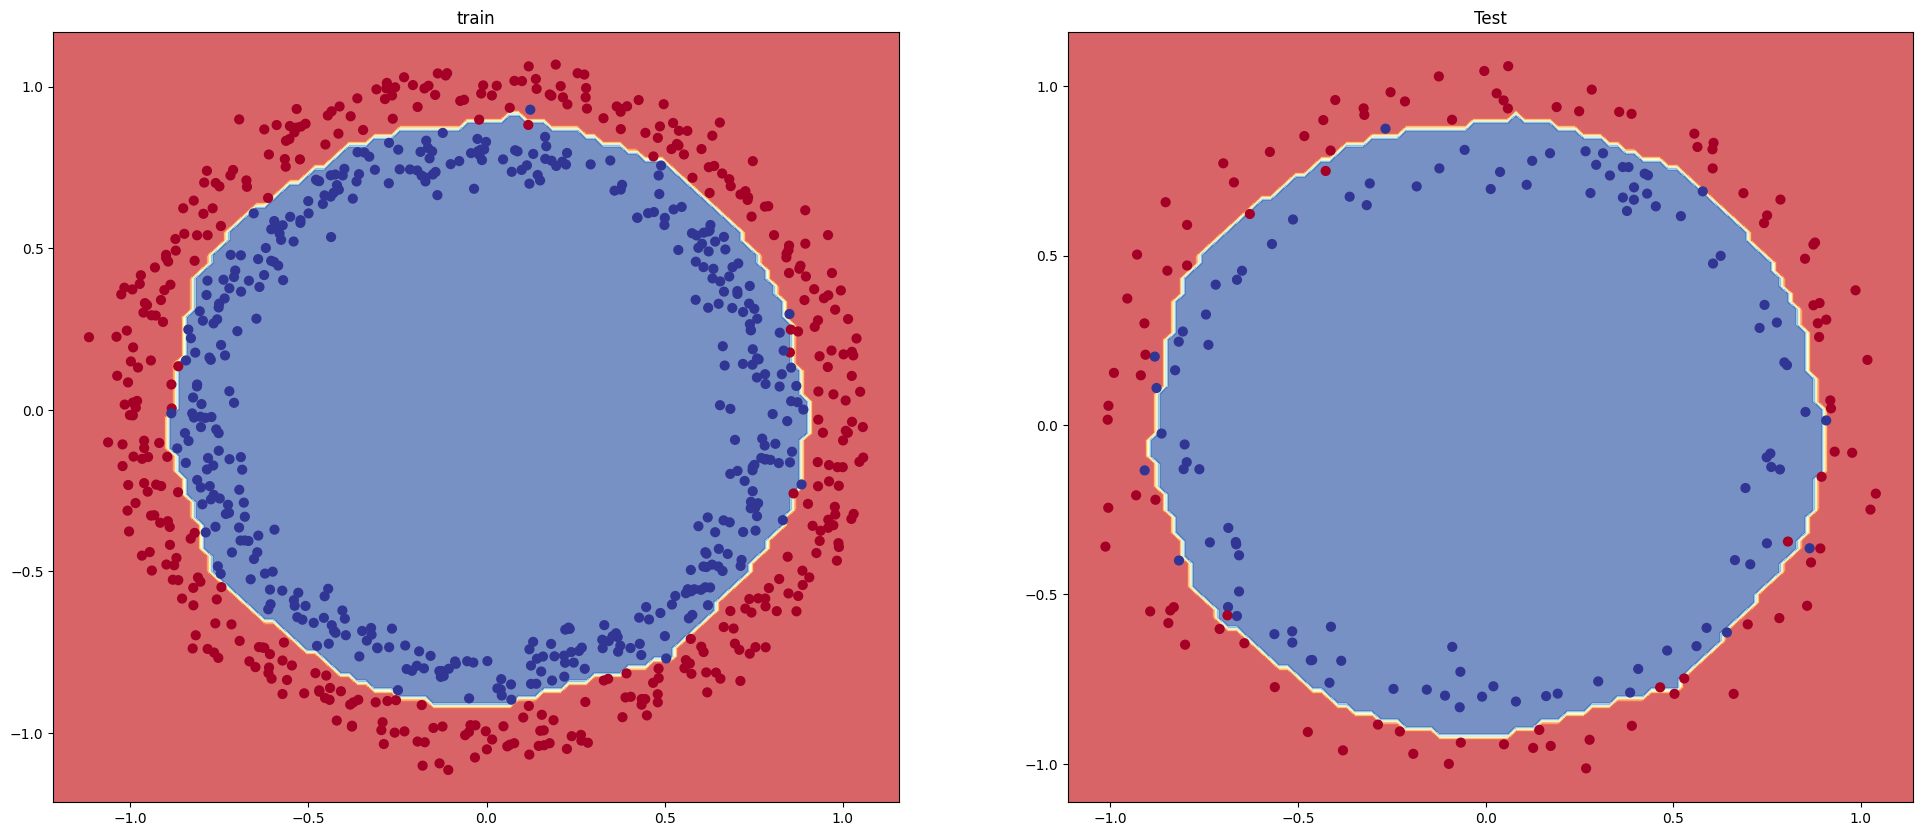

In [ ]:
plt.figure(figsize = (24 , 10))
plt.subplot(1 , 2 , 1)
plt.title("train")
plot_decision_boundary(best_model , X_train , y_train)
plt.subplot(1 , 2, 2)
plt.title("Test")
plot_decision_boundary(best_model , X_test , y_test)


### ***Try on Linear data***

As seen the model parforms badly on non linear data

In [ ]:
def y(data):
  X = data[0] + data[1]
  return X*5 + 1

x = torch.randn(1000 , 2)
data = [y(i) for i in x]
data = torch.tensor(data)

x = x.type(torch.float)
data = data.type(torch.float)

In [ ]:
new_x = x[:,0]

f = torch.zeros(new_x.shape)

new_data = np.array(list(zip(new_x , f))).astype(np.float32)
new_data = torch.from_numpy(new_data)

In [ ]:
new_y = torch.tensor(np.array([y(i) for i in new_data]).astype(np.float32))
new_y.shape , new_y[9] ,[new_data[9]]

(torch.Size([1000]), tensor(-1.6771), [tensor([-0.5354,  0.0000])])

In [ ]:
-1.8873 * 5 +1

-8.4365

In [ ]:
X_1 , X_2 , y_1 , y_2 = train_test_split(new_data , new_y , test_size = 0.2 , shuffle = True)

In [ ]:
model_1 = CircleModelV1()

loss_fn = torch.nn.L1Loss()
optim = torch.optim.SGD(params = model_1.parameters() , lr = 0.005)
epochs = 1000


for i in range(1 , epochs +1):

    model_1.train()

    y_preds = model_1(X_1).squeeze()

    loss = loss_fn(y_preds , y_1)
    # y_preds = torch.round(torch.sigmoid(y_logits))
    train_acc = accuracy_fn(y_1 , y_preds)

    optim.zero_grad()

    loss.backward()

    optim.step()

    model_1.eval()

    with torch.inference_mode():

        test_logits = model_1(X_2).squeeze()
        test_loss = loss_fn(test_logits , y_2)

        # test_preds = torch.round(torch.sigmoid(test_logits))

        test_acc = accuracy_fn(y_2 , test_logits)

    if i % 100 == 0:
      print(f"| {i} | Train loss {loss} | Train accuracy {train_acc}  || Test loss {test_loss} | Test accuracy {test_acc}")









| 100 | Train loss 3.9409983158111572 | Train accuracy 0.0  || Test loss 3.676614999771118 | Test accuracy 0.0
| 200 | Train loss 3.3068814277648926 | Train accuracy 0.0  || Test loss 3.080552101135254 | Test accuracy 0.0
| 300 | Train loss 0.7023626565933228 | Train accuracy 0.0  || Test loss 0.5912587642669678 | Test accuracy 0.0
| 400 | Train loss 0.2169295847415924 | Train accuracy 0.0  || Test loss 0.2739093005657196 | Test accuracy 0.0
| 500 | Train loss 0.14420795440673828 | Train accuracy 0.0  || Test loss 0.30455729365348816 | Test accuracy 0.0
| 600 | Train loss 0.21136054396629333 | Train accuracy 0.0  || Test loss 0.23166079819202423 | Test accuracy 0.0
| 700 | Train loss 0.23543965816497803 | Train accuracy 0.0  || Test loss 0.1858566254377365 | Test accuracy 0.0
| 800 | Train loss 0.19306327402591705 | Train accuracy 0.0  || Test loss 0.1606578379869461 | Test accuracy 0.0
| 900 | Train loss 0.17149284482002258 | Train accuracy 0.0  || Test loss 0.197565495967865 | Test a

#### ***Non - Linear on Multi-class Models***

In [ ]:
import torch
from torch import nn
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


device = 'cuda' if torch.cuda.is_available() else "cpu"

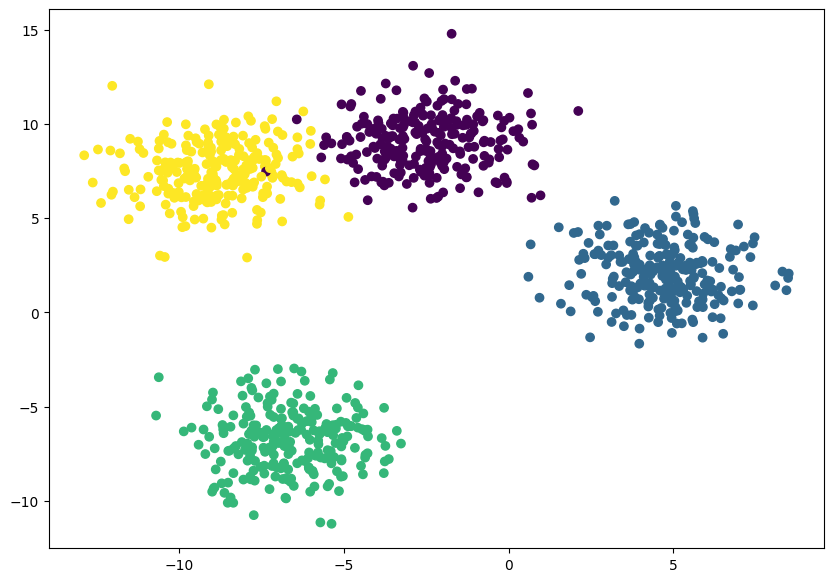

In [ ]:

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob , y_blob = make_blobs(n_samples = 1000,
                             n_features = NUM_FEATURES,
                             centers = NUM_CLASSES,
                             cluster_std = 1.5,
                             random_state = RANDOM_SEED
                             )

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)

plt.figure(figsize = (10 , 7))
plt.scatter(X_blob[:,0] , X_blob[:,1] , c= y_blob );


In [ ]:

X_blob_train , X_blob_test , y_blob_train , y_blob_test = train_test_split(X_blob , y_blob
                                                                            ,test_size = .2,
                                                                            random_state = RANDOM_SEED)

X_blob_train.requires_grad

False

In [ ]:
# from matplotlib import colormaps
# list(colormaps)

#### **Creating the model**


* when  predicting you

add and activation layer after the ouput using torch.softmax

model ouputs logits --> model probabilities --> index preds

In [ ]:

device = "cuda" if torch.cuda.is_available() else "cpu"

class BlobModel(torch.nn.Module):

      def __init__(self , input_features , output_features):
          super().__init__()

          self.l1 = nn.Linear(input_features , 10)
          self.l2 = nn.ReLU()
          self.l3 = nn.Linear(10 , 20)
          self.l4 = nn.Linear(20 , output_features)

      def forward(self, X):

        z = self.l1(X)
        z = self.l2(z)
        z = self.l3(z)
        z = self.l2(z)
        z = self.l4(z)

        return z



X_blob_train = X_blob_train.to(device)
X_blob_test = X_blob_test.to(device)
y_blob_train = y_blob_train.to(device)
y_blob_test = y_blob_test.to(device)


In [ ]:

import copy

### Training the model

loss_fn = torch.nn.CrossEntropyLoss()
blob_model = BlobModel(2 ,4).to(device)
optim = torch.optim.SGD(params = blob_model.parameters() , lr = 0.01)


epochs = 1000

loss_track = []
for i in range(1 , epochs + 1):
    blob_model.train()

    ### logits --> probabilities --> predicted index

    y_logits = blob_model(X_blob_train)

    loss_new = loss_fn(y_logits , y_blob_train)

    optim.zero_grad()

    loss_new.backward()


    optim.step()

    blob_model.eval()

    with torch.inference_mode():
      test_logits = blob_model(X_blob_test)

      test_loss = loss_fn(test_logits , y_blob_test)

    if i == 1:
      loss_track.append(test_loss)
      model_wo=  copy.deepcopy(blob_model)
      torch.save(model_wo.state_dict() , 'worst_weights.pt')


    else:

      if test_loss < min(loss_track):
        model_w=  copy.deepcopy(blob_model)

        torch.save(model_w.state_dict() , 'best_weights.pt')

        if i % 100 == 0:
          print(f"Training loss {loss_new} | test loss {test_loss}")

      loss_track.append(test_loss)




Training loss 0.29386866092681885 | test loss 0.29085785150527954
Training loss 0.10349194705486298 | test loss 0.09573864936828613
Training loss 0.06451556831598282 | test loss 0.05654022842645645
Training loss 0.04995892569422722 | test loss 0.041975464671850204
Training loss 0.04247947037220001 | test loss 0.03443235531449318
Training loss 0.03797563537955284 | test loss 0.02981448732316494
Training loss 0.034977272152900696 | test loss 0.026683323085308075
Training loss 0.032844606786966324 | test loss 0.02441391535103321
Training loss 0.03125837445259094 | test loss 0.02268570102751255
Training loss 0.03003557398915291 | test loss 0.021326659247279167


In [ ]:
model_weights  = torch.load("/content/best_weights.pt")
bad_weights = torch.load("/content/worst_weights.pt")
good_model = BlobModel(2 , 4)
bad_model = BlobModel(2,4)
good_model.load_state_dict(model_weights)
bad_model.load_state_dict(bad_weights)

<All keys matched successfully>

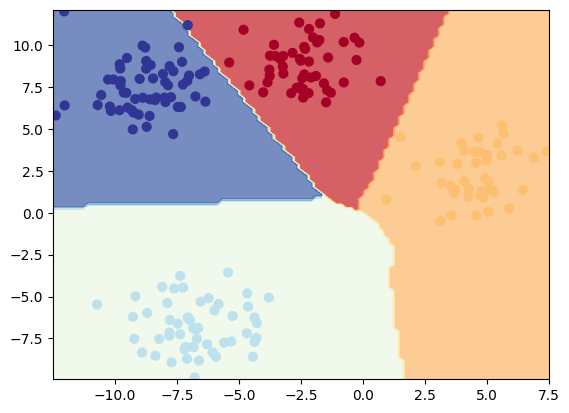

In [ ]:
plot_decision_boundary(good_model , X_blob_test , y_blob_test)

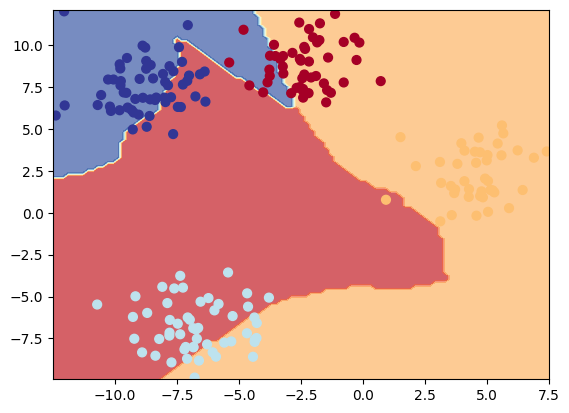

In [ ]:
plot_decision_boundary(bad_model , X_blob_test , y_blob_test)

### ***MODEL EVALUATION***


* Accuracy - Good when having ballannced classes

* Precision

* Recall

* F1-score

* Confusion matrix

* Classification report

* Roc curve

* Source  "https://lightning.ai/docs/torchmetrics/stable/classification/auroc.html

In [ ]:
!pip install torchmetrics

In [ ]:
import torchmetrics
from torchmetrics import AUROC , Accuracy , Recall , Precision
from torchmetrics.classification import MulticlassAccuracy  as MCA , MulticlassAUROC as MCAUROC , MulticlassRecall as MRC , MulticlassPrecision as MP
from torchmetrics.classification import MulticlassConfusionMatrix as MCM
from torchmetrics.classification import MulticlassF1Score as MF1


from sklearn.metrics import classification_report


In [ ]:
dir(torchmetrics)




In [ ]:
auroc = AUROC(task = 'multiclass' , num_classes = 4)

In [ ]:
### model prediction probabilities

#### AUROC
good_model.eval()
with torch.inference_mode():
    logits_preds = good_model(X_blob_test)

pred_probs = torch.softmax(logits_preds , dim = 1)

print(f"AREA UNDER CURVE : {auroc(pred_probs , y_blob_test)}")
g = MCAUROC(4)
g(pred_probs , y_blob_test)

AREA UNDER CURVE : 1.0


tensor(1.)

In [ ]:
### Recall and Precission
recall = MRC(4)
recall_val = recall(pred_probs , y_blob_test)

### Precision

Precission = MP(4)
precission_val = Precission(pred_probs , y_blob_test)

print(f"Precission {precission_val} || Recall {recall_val} ")


Precission 0.9950000047683716 || Recall 0.9956140518188477 


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Predicted class', ylabel='True class'>)

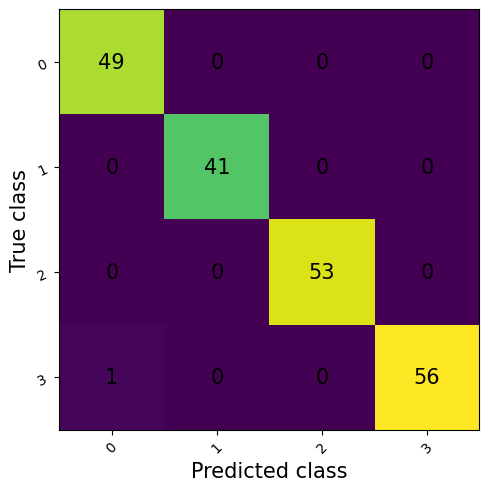

In [ ]:
### Multi class Confusion matrix

Matrix = MCM(4)
matrix = Matrix(pred_probs , y_blob_test)
Matrix.plot()

In [ ]:
#### F1 score

F1 = MF1(4)
f1_score = F1(pred_probs , y_blob_test)

print(f"F 1 Score {f1_score}")

F 1 Score 0.9952623248100281


In [ ]:
### using sklean classififcation report
### You need to pass the binary

y_preds = pred_probs.argmax(dim = 1)
report = classification_report(y_preds , y_blob_test)


In [ ]:
print(report)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        50
           1       1.00      1.00      1.00        41
           2       1.00      1.00      1.00        53
           3       0.98      1.00      0.99        56

    accuracy                           0.99       200
   macro avg       1.00      0.99      1.00       200
weighted avg       1.00      0.99      0.99       200

